# Preprocessing

## Install / Import all Python Modules Required

In [1]:
! pip install contractions

In [2]:
! pip install python-dotenv

In [3]:
! pip install nltk

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import string
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


from dotenv import load_dotenv, find_dotenv
import os

In [5]:
pd.set_option('display.max_colwidth', None)

## Load the Datasets required (Train Set, Validation Set, Test Set)

In [6]:
#loading the datasets
train_set = pd.read_csv('../raw_data/train.csv')
validation_set = pd.read_csv('../raw_data/validation.csv')
test_set = pd.read_csv('../raw_data/test.csv')

In [7]:
len(train_set)

287113

## Drop Useless Columns

In [8]:
# droppping useless columns
train_data = train_set.drop(['id', 'orig_id'], axis=1)[:200]
val_data = validation_set.drop(['id', 'orig_id'], axis=1)[:200]
test_data = test_set.drop(['id', 'orig_id'], axis=1)[:100]

In [9]:
train_data.shape

(200, 2)

In [10]:
train_data[6:8]

article  \
6  BAGHDAD, Iraq (CNN) -- The women are too afraid and ashamed to show their faces or have their real names used. They have been driven to sell their bodies to put food on the table for their children -- for as little as $8 a day. Suha, 37, is a mother of three. She says her husband thinks she is cleaning houses when she leaves home. "People shouldn't criticize women, or talk badly about them," says 37-year-old Suha as she adjusts the light colored scarf she wears these days to avoid extremists who insist women cover themselves. "They all say we have lost our way, but they never ask why we had to take this path." A mother of three, she wears light makeup, a gold pendant of Iraq around her neck, and an unexpected air of elegance about her. "I don't have money to take my kid to the doctor. I have to do anything that I can to preserve my child, because I am a mother," she says, explaining why she prostitutes herself. Anger and frustration rise in her voice as she speaks. "No matter what else I may be, no matter how off the path I may be, I am a mother!"  Watch a woman describe turning to prostitution to "save my child" » . Her clasped hands clench and unclench nervously. Suha's husband thinks that she is cleaning houses when she goes away. So does Karima's family. "At the start I was cleaning homes, but I wasn't making much. No matter how hard I worked it just wasn't enough," she says. Karima, clad in all black, adds, "My husband died of lung cancer nine months ago and left me with nothing." She has five children, ages 8 to 17. Her eldest son could work, but she's too afraid for his life to let him go into the streets, preferring to sacrifice herself than risk her child. She was solicited the first time when she was cleaning an office. "They took advantage of me," she says softly. "At first I rejected it, but then I realized I have to do it." Both Suha and Karima have clients that call them a couple times a week. Other women resort to trips to the market to find potential clients. Or they flag down vehicles. Prostitution is a choice more and more Iraqi women are making just to survive. "It's increasing," Suha says. "I found this 'thing' through my friend, and I have another friend in the same predicament as mine. Because of the circumstance, she is forced to do such things." Violence, increased cost of living, and lack of any sort of government aid leave women like these with few other options, according to humanitarian workers. "At this point there is a population of women who have to sell their bodies in order to keep their children alive," says Yanar Mohammed, head and founder of the Organization for Women's Freedom in Iraq. "It's a taboo that no one is speaking about." She adds, "There is a huge population of women who were the victims of war who had to sell their bodies, their souls and they lost it all. It crushes us to see them, but we have to work on it and that's why we started our team of women activists." Her team pounds the streets of Baghdad looking for these victims often too humiliated to come forward. "Most of the women that we find at hospitals [who] have tried to commit suicide" have been involved in prostitution, said Basma Rahim, a member of Mohammed's team. The team's aim is to compile information on specific cases and present it to Iraq's political parties -- to have them, as Mohammed puts it, "come tell us what [they] are ... going to do about this." Rahim tells the heartbreaking story of one woman they found who lives in a room with three of her children: "She has sex while her three children are in the room, but she makes them stand in separate corners." According to Rahim and Mohammed, most of the women they encounter say they are driven to prostitution by a desperate desire for survival in the dangerously violent and unforgiving circumstances in Iraq. "They took this path but they are not pleased," Rahim says. Karima says when she sees her children with food on the table, she is able to convi

In [11]:
print(f"train_data.shape: {train_data.shape}")

train_data.shape: (200, 2)


## Check if there are any Empty Cells in the DataFrame

In [12]:
train_data.isna().sum()

article       0
highlights    0
dtype: int64

In [13]:
test_data.isna().sum()

article       0
highlights    0
dtype: int64

## Dealing with Duplicates / Drop Duplicates in the Train, Validation and Test Sets

In [14]:
train_data.duplicated(subset=['article', 'highlights']).sum()

5

In [15]:
val_data.duplicated(subset=['article', 'highlights']).sum()

0

In [16]:
test_data.duplicated(subset=['article', 'highlights']).sum()

0

In [17]:
def del_duplicates(dataset, columns_to_compare):
    '''
    Function that deletes duplicated lines comapres according to indicated columns
    '''
    return dataset.drop_duplicates(subset=columns_to_compare)

In [18]:
cols = ['article', 'highlights']

train = del_duplicates(train_data, columns_to_compare=cols)
train.shape

(195, 2)

In [19]:
val = del_duplicates(val_data, columns_to_compare=cols)
val.shape

(200, 2)

In [20]:
test = del_duplicates(test_data, columns_to_compare=cols)
test.shape

(100, 2)

## Potential threshhold for news extraction / Check the Statistical Distribution of Word Counts for Articles and Summaries

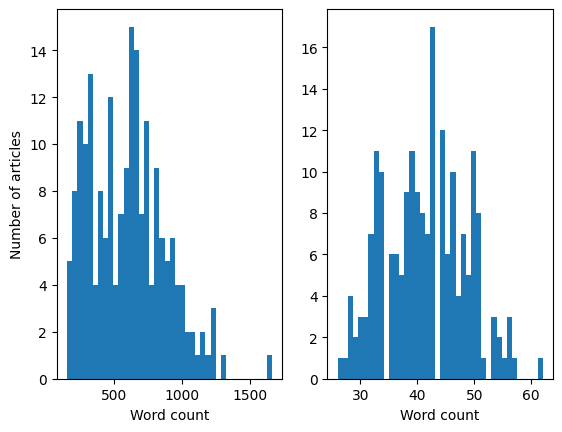

In [21]:
# word count
article_wc = []
summary_wc = []

# populate the lists with sentence lengths
for i in train.article:
      article_wc.append(len(i.split()))

for i in train.highlights:
      summary_wc.append(len(i.split()))

length_df = pd.DataFrame({'text':article_wc, 'summary':summary_wc})

plt.subplot(1, 2, 1)
plt.hist(length_df.text, bins=40)
plt.xlabel("Word count")
plt.ylabel("Number of articles")


plt.subplot(1, 2, 2)
plt.hist(length_df.summary, bins=40)
plt.xlabel("Word count")


plt.show()

## Clean the Data

### Prepare a Function "Preprocessing" to perform the single cleaning steps

- Transform upper cases to lower cases
- Remove return characters, url and html tags
- Expand shortened words via Contractions
- Remove any parentheses with text inside
- Remove special characters, remove whitespaces

In [22]:
def preprocessing(sentence: string, remove_stopwords=True) -> string: 
    
    '''
    Preprocessing text: lower case, 
                        deleting punctuation, 
                        replacing contructions with equivalent,
                        deleting stop words,
                        removing special characters
    '''

    # Lowercase
    sentence = sentence.lower()
   
    # Remove return characters, url and html tags
    code_list = ['\n', '\S*(http|https)\S*', '\<a href', '&amp;', '<br />']
    for code in code_list:
        sentence = re.sub(code, ' ',sentence, flags=re.MULTILINE)
    
    # expand the shortened words (can't => can not)
    # after they will be deleted in stopwords
    expanded = []   
    for word in sentence.split():
        expanded.append(contractions.fix(word, slang=False))
        
    expanded_sentence = ' '.join(expanded)
    
    # remove any parenthisis with text inside
    sentence = re.sub(r'\([^)]*\)', '', expanded_sentence)
        # Removing punctuation, url and html tags
    for punctuation in string.punctuation + '[\'\"]':
        sentence = sentence.replace(punctuation, ' ')
        
    # remove special characters 
    sentence = re.sub("[^a-zA-Z]", " ", sentence)

    # Removing whitespaces
    sentence = sentence.strip()
                
    if remove_stopwords:
        stop_words = set(stopwords.words('english')) ## defining stopwords    
        sentence_list = [w for w in sentence.split() if not w in stop_words]
        sentence = (' '.join(sentence_list)).strip()
        
    return sentence

### Test the function "Preprocessing" prepared to clean the data on a subset to check if it works

In [23]:
def cleaning(dataset: pd.Series, remove_stopwords=True) -> list:
    '''
    This function creates a cleaned version of each dataset.
    Calls the preprocessing function.
    '''
    
    clean = []
    for text in dataset:
        clean.append(preprocessing(text, remove_stopwords=True))
    return clean

In [24]:
%%time

X_train = cleaning(train.article)
y_train = cleaning(train.highlights, remove_stopwords=False)

CPU times: user 821 ms, sys: 44.3 ms, total: 865 ms
Wall time: 947 ms


In [25]:
print(f'Clean article : {X_train[0]}')
print('\n')
print(f'Clean summary : {y_train[0]}')

Clean article : london england harry potter star daniel radcliffe gains access reported million fortune turns monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnists around world young actor says plans fritter cash away fast cars drink celebrity parties plan one people soon turn suddenly buy massive sports car collection something similar told australian interviewer earlier month think particularly extravagant things like buying things cost pounds books cds dvds radcliffe able gamble casino buy drink pub see horror film hostel part ii currently six places number one movie uk box office chart details mark landmark birthday wraps agent publicist comment plans definitely sort party said interview hopefully none reading radcliffe earnings first five potter films held trust fund able touch despite growing fame riches actor says keeping feet firmly ground people always looking say kid star goes rails told reporters last month 

In [26]:
%%time

X_val = cleaning(val.article)
y_val = cleaning(val.highlights, remove_stopwords=False)

CPU times: user 1.05 s, sys: 62.5 ms, total: 1.11 s
Wall time: 1.43 s


In [27]:
%%time

X_test = cleaning(test.highlights, remove_stopwords=False)
y_test = cleaning(test.article)

CPU times: user 528 ms, sys: 40.3 ms, total: 568 ms
Wall time: 662 ms


### !!! Only for target data => adding "start" and "stop" to the sequence

In [28]:
def adding_decoder_tokens(data: pd.Series) -> pd.Series:
    '''
    Adding special tokens for the decoder only to target string
    '''
    
    return pd.Series(data).apply(lambda x : '_START_ '+ x + ' _END_')

y_train = adding_decoder_tokens(y_train)
y_val = adding_decoder_tokens(y_val)

In [29]:
y_train[0]

'_START_ harry potter star daniel radcliffe gets fortune turns monday young actor says plans fritter cash away radcliffe earnings first five potter films held trust fund _END_'

# Tokenization

## Initialize the max len for Article and Summary

In [30]:
# initialize the max len for article and summary
max_len_text = 150
max_len_summary= 10

## Article Tokenization

### Transform each Article in articles to a sequence of Integers

The result of this step are the lists X_train_tok and X_val_tok that basically are lists of tokenized articles in turn being lists of words transformed to integers

In [31]:
# learning the dictionnary from train articles
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

# Transforms each article in articles to a sequence of integers.
X_train_tok = X_tokenizer.texts_to_sequences(X_train) 
X_val_tok = X_tokenizer.texts_to_sequences(X_val)

In [32]:
print('Tokenized article looks like this : ')
print(X_train_tok[0])

Tokenized article looks like this : 
[106, 153, 876, 1941, 445, 3666, 3008, 4693, 877, 154, 104, 2547, 1514, 135, 3009, 265, 2548, 3667, 3666, 3008, 876, 1941, 876, 1941, 277, 3010, 3011, 6686, 6687, 107, 23, 228, 1942, 28, 878, 6688, 1018, 168, 1703, 1019, 2549, 1515, 2550, 945, 2, 3, 638, 527, 2551, 804, 1516, 749, 169, 2552, 217, 1517, 17, 1020, 6689, 124, 80, 68, 1121, 6690, 170, 20, 3668, 170, 695, 946, 3669, 6691, 6692, 3008, 292, 4694, 2216, 804, 2549, 4695, 38, 2553, 947, 6693, 85, 1943, 1704, 70, 948, 145, 2, 1233, 416, 1705, 249, 4696, 1122, 1021, 6694, 2217, 6695, 1706, 6696, 1944, 878, 2554, 1364, 466, 1, 1365, 4697, 879, 1366, 3008, 4698, 14, 90, 1941, 2555, 250, 1945, 880, 292, 1946, 602, 881, 3670, 4699, 1942, 28, 2556, 502, 4700, 391, 3, 417, 528, 40, 1947, 445, 558, 6697, 17, 418, 19, 80, 467, 236, 81, 37, 4, 949, 529, 3671, 278, 6698, 876, 1941, 277, 3010, 1707, 1234, 2557, 3012, 6699, 696, 19, 10, 2555, 32, 2218, 315, 1367, 1941, 529, 60, 1022, 1941, 218, 6700, 4701,

### Pad the Tokenized Articles to max_len_text

- The padding step shall ensure that all tokenized articles are split in a way that the results are lists of integers all having the same length max_len_text
- If a tokenized article is longer than max_len_text it is truncated
- If a tokenized article is shorter than max_len_text it is filled with 0's to reach a length of max_len_text

In [33]:
# post-padding with zeros up to maximum length
X_train_pad = pad_sequences(X_train_tok, dtype='float32', maxlen=max_len_text, padding='post') 
X_val_pad = pad_sequences(X_val_tok, dtype='float32', maxlen=max_len_text, padding='post')

X_vocab = len(X_tokenizer.word_index) + 1

In [34]:
print(f'The size of train articles vocabulary is {X_vocab}')

The size of train articles vocabulary is 12347


## Summary Tokenization

### Tokenize Summaries to lists of Integers

In [35]:
# learning the dictionnary from train summaries
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

# Transforms each summary in summaries to a sequence of integers.
y_train_tok = y_tokenizer.texts_to_sequences(y_train) 
y_val_tok = y_tokenizer.texts_to_sequences(y_val) 

### Pad the tokenized Summaries to a Length of max_len_summary

In [36]:
# post-padding with zeros up to maximum length
y_train_pad = pad_sequences(y_train_tok, dtype='float32', maxlen=max_len_summary, padding='post')
y_val_pad = pad_sequences(y_val_tok,  dtype='float32', maxlen=max_len_summary, padding='post')

y_vocab = len(y_tokenizer.word_index) + 1

In [37]:
print(f'The size of train summary vocabulary is {y_vocab}')

The size of train summary vocabulary is 2712


# Build the Model that will be Trained and will Predict Summaries of Articles based on the Training Performed

## Import Modules Potentially Required

In [38]:
import numpy as np
from keras import backend as K
from tensorflow.keras import optimizers
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings("ignore")

## Define latent_dim & embedding_dim

- latent_dim is the dimension intended for the output of the Encoder, i.e. the first step of the Model
- embedding_dim is

In [39]:
latent_dim = 750
embedding_dim = 100

--------------------------------------------------------------------

## Step 1 of the Model: Embed the Inputs to the Encoder into the Latent Space

- The Encoder allocates the integers (being included in the tokenized and padded lists of integers) inserted into the Model into Vectors in the "Latent Space"
- Input shape is max_len_text as via the step before we have padded the lists of integers to a length of max_len_text
- X_Vocab is the length of the X_Tokenizer Word Index + 1, i.e. the number of integers + 1. Why "+1"? xxx
- latent_dim is the dimensionality of the output space
- The result of the Encoder, "enc_emb", is a Tensor having the shape (None, 300, 300)

In [40]:
# Add documentation for encoder
# shape: max_len_text, i.e. the maximum length of words of the input text we will insert into the model, correct?
# Embedding: X_vocab is the length of the X_Tokenizer Word Index + 1
# Embedding: latent_dim is the dimensionality of the output space

encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(X_vocab, latent_dim,trainable=True)(encoder_inputs)

2022-12-06 20:40:14.600079: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
enc_emb

<KerasTensor: shape=(None, 150, 750) dtype=float32 (created by layer 'embedding')>

## Step 2 of the Model: Three Stages of Stacked Long Short Term Memory (LSTM) Acting as the Encoder

There are three LSTM layers

The outputs of this step are

- encoder_outputs being a tensor with shape (None, max_len_text, max_len_text)
- state_h being a tensor with shape (none, max_len_text)
- state_c being a tensor with shape (none, max_len_text)

In [42]:
# LSTM 1 
# first integer shown in the brackets is the "dimensionality of the output space". so, that would be the length of the output summary, right?
# return_sequences = Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
# return_state = Boolean. Whether to return the last state in addition to the output. Default: False.

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [43]:
encoder_output1

<KerasTensor: shape=(None, 150, 750) dtype=float32 (created by layer 'lstm')>

In [44]:
encoder_output2

<KerasTensor: shape=(None, 150, 750) dtype=float32 (created by layer 'lstm_1')>

In [45]:
encoder_outputs

<KerasTensor: shape=(None, 150, 750) dtype=float32 (created by layer 'lstm_2')>

In [46]:
state_h

<KerasTensor: shape=(None, 750) dtype=float32 (created by layer 'lstm_2')>

In [47]:
state_c

<KerasTensor: shape=(None, 750) dtype=float32 (created by layer 'lstm_2')>

In [48]:
encoder_outputs

<KerasTensor: shape=(None, 150, 750) dtype=float32 (created by layer 'lstm_2')>

## Step 3 of the Model: Setup the Decoder

In [49]:
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_vocab, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs)

In [50]:
dec_emb

<KerasTensor: shape=(None, None, 750) dtype=float32 (created by layer 'embedding_1')>

### Decoder based on encoder_states as initial state

In [51]:
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

### Attention Layer

In [52]:
#attn_layer = Attention(name='attention_layer') 
#attn_out = attn_layer([encoder_outputs, decoder_outputs]) 

attention = Attention(name='attention_layer')
attn_out = attention([decoder_outputs, encoder_outputs])

In [53]:
decoder_outputs

<KerasTensor: shape=(None, None, 750) dtype=float32 (created by layer 'lstm_3')>

In [54]:
encoder_outputs

<KerasTensor: shape=(None, 150, 750) dtype=float32 (created by layer 'lstm_2')>

### Concatenate attention output and decoder LSTM output 

In [55]:
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [56]:
decoder_concat_input

<KerasTensor: shape=(None, None, 1500) dtype=float32 (created by layer 'concat_layer')>

### Add a Dense Layer

In [57]:
#decoder_dense = Dense(y_vocab, activation='softmax')
decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax')) 
#decoder_outputs = decoder_dense(decoder_outputs)
decoder_outputs = decoder_dense(decoder_concat_input)

In [58]:
decoder_outputs

<KerasTensor: shape=(None, None, 2712) dtype=float32 (created by layer 'time_distributed')>

## Step 4: Define the Model

In [59]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 750)     9260250     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 150, 750),   4503000     ['embedding[0][0]']              
                                 (None, 750),                                                     
                                 (None, 750)]                                                     
                                                                                              

## Step 5: Compile and Train the Model

In [61]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)

In [62]:
#opt = optimizers.RMSprop(learning_rate=0.00001)
model.compile( 
    #optimizer = opt, loss="sparse_categorical_crossentropy")
    optimizer="rmsprop", loss="sparse_categorical_crossentropy") 
history = model.fit( 
    [X_train_pad,y_train_pad[:,:-1]],
    y_train_pad.reshape(len(y_train_pad), max_len_summary, 1)[:,1:], 
    batch_size=200, 
    epochs=50,
    callbacks=[es],
    validation_data=([X_val_pad,y_val_pad[:,:-1]], y_val_pad.reshape(y_val_pad.shape[0],y_val_pad.shape[1], 1)[:,1:])
    #validation_split=0.1,
    )
 
#Save model
model.save("s2s")

Epoch 1/50


2022-12-06 20:40:34.497762: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 1200 num_cores: 4 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 4194304 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - ETA: 0s - loss: 7.9055

2022-12-06 20:41:42.158582: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 1200 num_cores: 4 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 4194304 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 99s 99s/step - loss: 7.9055 - val_loss: 7.8812
Epoch 2/50
1/1 [==============================] - 76s 76s/step - loss: 7.8504 - val_loss: 7.5012
Epoch 3/50
1/1 [==============================] - 77s 77s/step - loss: 6.8627 - val_loss: 8.6775
Epoch 4/50
1/1 [==============================] - 76s 76s/step - loss: 8.3864 - val_loss: 8.5747
Epoch 5/50
1/1 [==============================] - 74s 74s/step - loss: 7.2583 - val_loss: 9.0850
Epoch 5: early stopping


2022-12-06 20:48:04.953670: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


## Diagnostics enabling us to check the course of losses for training and validation

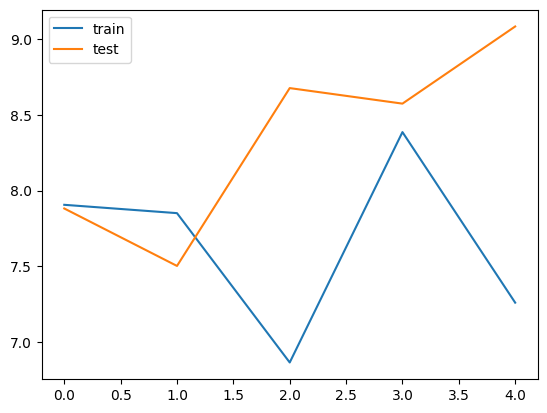

In [67]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [68]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=X_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

## Inference Process

In [69]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attention = model.layers[8]
attn_out_inf = attention([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
#decoder_outputs2 = decoder_dense(decoder_inf_concat)
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [70]:
state_h2

<KerasTensor: shape=(None, 750) dtype=float32 (created by layer 'lstm_3')>

In [71]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 750)    2034000     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 750)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 750)]        0           []                               
                                                                                            

In [72]:
decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

[<KerasTensor: shape=(None, None, 750) dtype=float32 (created by layer 'lstm_3')>,
 <KerasTensor: shape=(None, 750) dtype=float32 (created by layer 'lstm_3')>,
 <KerasTensor: shape=(None, 750) dtype=float32 (created by layer 'lstm_3')>]

In [73]:
decoder_hidden_state_input

<KerasTensor: shape=(None, 150, 750) dtype=float32 (created by layer 'input_5')>

## Function implementing the Inference Process

In [74]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

## Function to transform Integers back to Words for our source sequence of Words



In [75]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

## Function to transform Integers back to Words for our target sequence of Words

In [76]:
def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

# Show the Output of our Model

In [77]:
for i in range(len(X_val_pad)):
    print("Review:",seq2text(X_val_pad[i]))
    print("Original summary:",seq2summary(y_val_pad[i]))
    print("Predicted summary:",decode_sequence(X_val_pad[i].reshape(1,max_len_text)))
    print("\n")

Review: would called donation bit surgical square four people cross partners temporarily everybody goes home smiling instead square generous move set chain reaction like falling kidney removed thursday went recipient donor donor kidney went next recipient also donor friday last donor give kidney someone time one deceased donor lists complete chain long chain rare done california pacific medical center said statement matching people chain taken long time changed computer named david jacobs received kidney transplant waiting deceased donor list live donor came along someone nice enough give away kidney stranger jacobs paid forward programming skills creating program genetically matches donor quickly five way years ago one largest took three four months three weeks jacobs said chain would worked quickly without generosity may worked altruistic donor opens possibilities donors said dr steven three four options inclusion altruistic donor options consider matching donors divine friend shirle

2022-12-06 20:48:20.396166: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 1200 num_cores: 4 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 4194304 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Predicted summary:  explorers explorers explorers explorers explorers explorers donated resolution resolution


Review: help grow yet describes importance placing emphasis attracting younger players european talented individuals sell value league clubs move biggest leagues across atlantic least money league player development attracting yet players turn raise standard early example strategy perhaps found transfer spanish midfielder moved sporting kansas sporting lisbon last year deal arrived free transfer aged released fc barcelona excelled kansas winning cup sold portuguese giants profit june quick make clear plans would need good systems truly could also achieved signing closer peak stage career added last point something appears happening already used lot big names could longer run europe said villa old guy lampard still going strong could still offer something teams europe said way example new york city first nevertheless continued signing young players big potential probably somet

Predicted summary:  explorers explorers explorers explorers explorers explorers donated resolution resolution


Review: english football governing body said players charged relation alleged breach fa rule e around th minute game two players incidents seen match officials caught video players friday respond charge could face six game bans found guilty evans released statements day incident evans saying would like make clear statement said reacted something found sometimes hard react particularly heat moment always tried hard positive role model especially young fans yesterday let spitting another player considered beyond professional former liverpool midfielder tv told bbc match day programme incident acceptable said kids watching something done towards referee weekly basis ex manchester united midfielder paul said believe evans deliberately telling sport look nice think jonny spitting floor know jonny type person wants hard miss stood yard away afterwards former liverpool player steve 

Predicted summary:  explorers explorers explorers explorers explorers explorers donated donated resolution


Review: strength women truly assist must opportunities million refugees registered unhcr un refugee agency less eventually resettled rest remain forced new lives places often right work refugees displaced average years half disappear urban struggle start lives humanitarian assistance media attention tend immediate aid cash food items unhcr provides critical cash assistance refugees jordan little month times country poverty line refugees need supplement yet cannot legally find working sector dangerous zainab among hundreds women finding world options build skills financial increased role earners challenges cultural exposing abuse violence women ability generate income guarantee economic independence help network women control income earn near east foundation discussions male family members wives daughters roles beginning women shy talk says heads islamic society community organiz

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: schools pakistan renamed honor children killed taliban siege school last year according provincial government local schools bear name student killed december attack army public school government spokesman told cnn gesture way remember students taking taliban militants strapped explosives laid siege six hours later dead children according authorities february pakistani authorities arrested suspect accusing attack army public school home students staff sons daughters army personnel around cnn mariano contributed report 
Original summary: students killed taliban attack six hour school killed people 
Predicted summary:  says says says says says says says says says


Review: army south africa using spread different kind message colors black blue organization using sensation spread awareness domestic violence ad shows model wearing white gold dress one caused internet last w

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: patrol car window people serve sheet glass vehicle person world around beat old movies bridge police forces people serve another idea give brought many law enforcement officials touch community lack community one cited report ferguson areas gulf law enforcement neighborhood wide used initially bring two sides together sides ultimately goal safe peaceful neighborhoods police departments members community take steps come together professional level tech services company south bronx recently hosted video game competition police officers residents neighborhood event left local teenagers saying things like basically like us ultimately police considered members community needs encouraged police departments neighborhoods alike communities make local part neighborhood celebrations new orleans police winston became minor internet celebrity dancing local people besides fun commu

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: sure happened far hard imagine would gone ahead without knowledge view makes gop efforts look extreme kennedy went behind scenes point foreign policy always deeply partisan matter often end challenge executive authority true spirit constitution country expected speak one voice foreign policy president always possible recall congress carter white house apart canal treaties administration policy controversial staffers sent aid rebels back channels democratic house speaker jim wright accused private peace plan left wing government bill clinton nuclear deal north korea criticized republicans democrats liberal democrats best iraq war writes foreign policy generally conducted white house executive agreements pass without comment idea foreign policy beyond na disagreements gone public political conditions appropriate particular matter iran talks sensitive republicans involves

Predicted summary:  explorers explorers explorers explorers explorers explorers donated donated resolution


Review: indian wanted get said moore fact would like welcome whole family think quite place successful enter take wild card coming family members williams suggestions sisters match indian fixed throughout whole career integrity everything told time also everything false allegations matches fixed hurt cut ripped us deeply current painful unfair game loved heart one tournaments suddenly felt alone afraid incident chief executive women tour said williams suffering genuine injury richard williams dictated outcome matches daughters mark admitted things could handled better williams example might explained withdrawal fans court signed said citing example last year world tour finals roger federer withdrew final london addressed fans signed happened final williams said thought horrible told cnn com thought tough players time would known enough know significantly injured set kind thought

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: striking image new baby american flag held navy sailor whose face cannot see photograph american flag navy veteran virginia beach whose filled sweet images parents shot picture sailor baby posted facebook page believe picture right shows means american told cnn affiliate flag uniform baby exactly every service member fighting everyone agreed navy wife whose husband deployed facebook page titled call posted photo said use flag bad picture u flag code state flag never used wearing never drawn back always allowed fall free according congressional research service report used receiving holding carrying anything threatening private messages reported facebook saddened decided keep posting picture take pictures members military request picture flag people posting critical facebook page disagree criticism picture wrote one poster veteran find picture beautiful clearly military

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: went isolation housing campus university nebraska medical center according spokesman taylor wilson atlanta workers voluntarily agreed leave housing monitored stay wilson said another set three workers arrived sunday morning housing near national health workers freedom move around ones georgia nebraska according christopher spokesman maryland department health state follow guidelines monitored individuals getting public transportation allow go outside long stay least feet away people number two workers arrived monday morning atlanta housing near third worker expected arrive monday atlanta health authorities deemed person lower risk allowed monitoring home according government official patient second admitted hospital safety nina texas health hospital dallas admitted october disease national thomas eric duncan recovered released free disease duncan died nebraska three fo

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: two state solution reduction cost living founder ben says prime minister benjamin failed think way go forward account change government get current government office get bibi office says ben organizers promoting specific candidate pushing voters toward political party march instead encouraging voters change current administration police estimated crowd people headlining rally former head israel agency critic recent weeks criticized decision speak u congress continued criticism rally saying never seen israeli politics still broad support israel party well polls union primary challenger initial round immediately following speech congress union expected win seats expected win seats poll comes cnn affiliate channel israel nature israeli politics party could lose election still becomes prime minister many ways rally similar social movement began summer hundreds thousands pr

Predicted summary:  explorers explorers explorers explorers explorers explorers donated donated resolution


Review: considered part islamic republic head jewish community comment directly political matters especially current heated environment say members community felt much home iran israel iran countries said consider iranian israeli israel iran affect us even jewish representative iran parliament aside vibrant jewish community city also several representing christian community business people center town shopping mall known people jewish passage many businesses jewish owned crew arrived found muslim jewish shop owners around one said owns clothing store friends call showed us hebrew prayer books always keeps store like others keen talk israeli prime minister benjamin recent address u congress problems israel iran says politics place want peace said really hope problems one day god willing hoping unity peace days community leaders conduct religious studies younger members congregati

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: despite head still possess ability prove human anyone notoriously unforgiving things matter label attached capacity desire accomplish something positive impact even prison cannot hope conviction future settled anyone many people asked recent days transformed kelly kelly journey hope struggle find words know kelly story pushes logic christian faith limits pushes christians proclaim forgiveness hope indeed even professional life long pastors struggle weight claims make today kelly life balance state georgia monday issued last minute execution citing concerns drugs used kill department corrections said plans resume executions analysis drugs complete gov deal power kelly sentence life prison join faith leaders across nation including georgia signed letter urging governor use political influence save kelly life speak publicly execution call people good reach gov deal georgi

Predicted summary:  explorers explorers explorers explorers explorers explorers donated resolution resolution


Review: often simply treated johns caught often pay fine go way outrageous tolerated longer joined forces advocacy groups fight modern day trade provide hope opportunity victims two bills introduced combat crime recently passed senate judiciary committee strong support opportunity senate justice victims trafficking act would support victims taking fines criminal assets convicted human traffickers toward services treatment help victims restore lives help victims also arms law enforcement tools go human traffickers ensures criminals including johns brought justice laws financial mask assault child second bill minnesota safe harbor law helps make sure minors sold sex prosecuted defendants instead treated victims stop exploitation trafficking act would give states safe harbor state passes safe harbor law means kids sold sex steered towards child protection services rather arreste

Predicted summary:  explorers explorers explorers explorers explorers explorers donated donated resolution


Review: thoughts prayers time pero pero died appears massive heart attack longtime agent dan told cnn sore arm week took days tour band says pero tour band new york scheduled play tonight according twisted sister jay jay french told cnn pero found morning tour bus taken hospital died devastated great guy one best french said lose someone years know going like stage without cannot even think like twisted sister death today lost brother anthony pero passed away said statement assault drums helped drive twisted sister inspired rock every single show heart breaks knowing never feel power beat behind turn see face smiling sheer joy got loved pero joined twisted sister best known song going take video though left time join another band twisted sister band past years according com going take video also animal house mark pero seen concert hitting brings cloud recent years also band cnn 

Predicted summary:  becomes explorers explorers explorers explorers explorers bremen bremen bremen


Review: last week alaska native received silver star aid wounded buddy afghanistan small team moved compound july searching expert explosive devices sergeant wounded without waiting reinforcements compound took enemy insurgent tried help enemy fire wounded sergeant survive marines never leave anybody behind marine maj gen joseph l said ceremony camp wife named marine year organization cited afghanistan commander description marine common sense every task family moved holland michigan teen deployed iraq sent afghanistan couple years later lived virginia city important early history colonies move toward independence britain born germany graduated high school virginia deployments included kosovo iraq afghanistan marine corps association foundation named critical skills year marine leaves behind wife son native ridge new jersey shaw captain team high school student government president ridg

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: press pursue many republicans hearings without looking like hard short story may soon die trust says clever fact instead neutral trusted party like lee hamilton review emails chose cut story destroying evidence comes price freshly public doubts whether plays straight rules democrats continue invest faith many others controversy leaves sense always going face rough campaign begin already gathering point real strengths leader around world many women look upon admiration years promoting also strong case make husband know something job creation million created eight clinton years presidency since world war ii short worse controversy broke american politics bill clinton likes say politics always tomorrow right candidates also need remember learn yesterday last week might start reading wonderful book barbara tuchman published years ago march folly vietnam argues leaders ofte

Predicted summary:  explorers explorers explorers explorers explorers explorers donated donated resolution


Review: palestinian man four israeli border police driving friday authorities first said witnesses said man drove side road hit victims taken hospital light injuries authorities incident terror attack according police spokesman suspect tried escape shot security guard severely wounded taken custody police said israeli police identified palestinian man early east attack movement blesses act considers natural response crimes abu spokesman posted facebook regional tensions tensions killings israeli teens palestinian boys marked run conflict israel summer took dozens israeli lives palestinian lives cnn michael contributed report 
Original summary: four border police hit suspect shot 
Predicted summary:  says says says says says says says says says


Review: want take self portrait using new stick front london national gallery fine try use inside museum national gallery become latest

Predicted summary:  becomes explorers explorers explorers explorers explorers bremen bremen bremen


Review: organizations governments added world away computer free home chicago daughter iranian american doctor father polish american mother little contact computers started studying college across line security staff today find women like far though last years hired female tech admits obvious valley fault clearly numbers make think problem women working security women working technology said make think problem culture atmosphere enough training sessions first asks new recruits computer machine idea need super genius computer reality think anybody real world think non software examples said lot people ask best answer given machine problem real answer none people think would steal favorite snack people figure steal entire machine people figure could add sort machine job much know understanding psychology attackers anybody working defense police officers security law enforcement stop thin

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: singer david hit car sunday evening spokesman said accident happened santa california near lives driving approximately mph struck according california highway patrol spokesman posted speed limit suffered multiple hospital santa barbara said injuries believed life threatening mr cooperative authorities way mr see sun said according spokesman side road supposed left side road walking toward traffic said considered known sweet belongs celebrated rock group nash david obviously upset accidentally hit anyone based initial reports relieved injuries life threatening said michael spokesman wishes recovery 
Original summary: santa california near suffered multiple injuries believed life 
Predicted summary:  says says says says says says says says says


Review: started wednesday iraqi coalition forces battling control strikes intended destroy saving innocent iraqi lives collate

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: bbc suspended host car show top gear following bbc producer broadcaster said statement suspended pending investigation said one else suspended top gear broadcast sunday fans expressed decision time writing people signed petition seeking using users show would without also took posting leader ed miliband knocking news agenda save co host james may save empty boxes cuts string far first time center controversy may year television asked forgiveness using term show n word children version take never aired last year bbc show hit headlines argentina complained top gear special filmed country number plate h used reference war forced stop filming leave country said bbc use plate previous article bbc said man given considered opinion statement corporation comment hated loved elite 
Original summary: involved top due air sunday schedule 
Predicted summary:  becomes explorers exp

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: son thought idea walking home school idea going christian grey said first laughed discussed friends saw side decided quite good costume idea school called say costume appropriate would take part book day event appear told paper teacher school dressed killer said see sex offensive murder told bbc news son read book watched movie spin aware media around tale cable ties supposed represent children age told bbc costume light laugh cheek offense friday image offensive book day costume inappropriate told change character would include photos also required phone call home regarding matter yet appropriate teacher dress killer students come guns thought christian grey talked book character past years sale high school issued statement saying actions high standards terms student behavior welfare safeguarding student taking part activities reported costume able fully participate e

Predicted summary:  explorers explorers explorers explorers explorers explorers donated resolution resolution


Review: said statement booked airline travel wednesday chicago arrive thursday presented undercover informant plans attacks military facility prosecutors said west one defendants currently wears uniform allegedly planned attack said statement conspiring provide material support foreign terrorist organization carries maximum penalty years prison fine number foreign fighters traveling join ranks increasing alarming rate top u official said last month fighters countries traveled battlefield according testimony nicholas director national center house homeland security committee rate foreign fighters traveling syria exceeds rate travelers went afghanistan pakistan iraq yemen somalia point last years said fighters estimated believed come western countries including united states officials said u air force veteran allegedly tried join turned back authorities could get syria pleaded 

Predicted summary:  explorers explorers explorers explorers explorers explorers donated resolution resolution


Review: spokesman main opposition party congress congress says vote voters intimidated demanded elections held rivers state canceled ruling party democratic party accusation saying election credible result reflects overwhelming wish people rivers state support president jonathan heavy rain eventually forced protesters home fears take rain stop protests violence concerned seems happening said nigeria election chairman events rivers state nigeria held thought closest elections since return democracy decades military rule two main candidates incumbent president jonathan retired general stake protests rivers state whether nigeria hold election hold close election voting results counted says final result likely announced within hours fear results may accepted opposition believes victory ruling party protests rivers state could spread northern nigeria people killed post election vi

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: said endured article also suggested school failed respond alleged assault released statement monday saying story done significant damage importance sexual assault issues america college campuses fraternity asked rolling stone fully story rolling stone editors said chose contact man allegedly attack jackie men said participated alleged assault editors feared magazine said adding regretted decision face new information appear jackie account come conclusion trust rolling stone said december rolling stone managing editor dana later truth would better served getting side story rolling stone issued article began fact check steve columbia university graduate school leading independent review cnn senior media correspondent brian reported sunday said much speculation findings columbia university review published early april magazine cannot really say surprised since much eviden

Predicted summary:  explorers explorers explorers explorers explorers explorers explorers donated resolution


Review: news comes companion went development season picked series second season code names including cobalt fear walking dead march announced series pickup series created walking dead comic series co wrote pilot dave erickson sons anarchy erickson executive produce alongside walking dead dave erickson serve adam direct pilot walking dead visual effects guru also executive produce series tight series premise sources tell hollywood reporter drama takes place los angeles confirmed companion series set los angeles revealed nothing beyond focus new read walking dead shocking deaths stars sean teacher shares son ex wife sons anarchy kim set co star nancy counselor works school sean seeing frank co stars nancy son nick battled drug problem play nancy daughter opposite nick dreams leaving los angeles strikes fear walking dead premiere late summer season two set official premiere date

Predicted summary:  explorers explorers explorers explorers explorers explorers donated resolution resolution


Review: brave trash souls common humans earned feel safe even seems impossible us understand apparently anyone explain keeps huge metal air truth history accidents pilots different people careless lazy drink much pilots talk among mistakes close calls disasters averted sheer luck favorite pilots slip little ways time time drama aviation actors audience besides flying routine hours boredom clich goes moments sheer terror long since airplanes wonderfully usually protect even worst pilot pilots higher moral type rest us despite occasionally utter pilots shoulder burden hundreds lives feel responsible full empty one pilots large proud identify extension self pilot feels motive deliver destination feel driving car crowded pilot values smooth landing skill people back still alive greatest guarantee pilot devoted safety fact time time pilot something completely confidence pilots dra